# Churn Prediction
Pattern
There are 3 aggregated reasons of Churn (resignation of service by client) defined by Payability customer service:
    1. No longer active on Amazon (27% last 12 mths)
        I. Supplier’s sales decline, leading to end of business
    2. Outgrew Payability (27% last 12 mths)
        I. Supplier’s sales significantly incline and Supplier is getting other financing
    3. Product complaint (46% last 12 mths)
    
    
### Task
Analyse first 2 points of above Churn reasons.

Having sales history data, prepare a model classifying the trend of sales as inclining or declining [or any other you see useful] and test the accuracy of model on given dataset. 

Check whether is there correlation of trend movement to churn event (churn happened if there is a date given in churn dataset – if there is no date, the client is still using our service) 
– verify the hipothesis stated by Customer Service.

Provide GitHub (or any similar, BitBucket etc.) link to Python script that you created during the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Data Loading

In [2]:
churnData = pd.read_csv("churn_data.csv",sep = ";")
churnData = churnData.drop(churnData.columns[0], axis=1)
churnData = churnData.set_index("supplier_key")
churnData['churn_date'] = pd.to_datetime(churnData['churn_date'])

In [3]:
sellerPerformance = pd.read_csv("seller_performance_data.csv",sep = ";", decimal=",")
sellerPerformance = sellerPerformance.drop(sellerPerformance.columns[0], axis=1)
sellerPerformance['report_date'] = pd.to_datetime(sellerPerformance['report_date'])

In [4]:
sellerPerformance = sellerPerformance.set_index("supplier_key")
sellerPerformance = sellerPerformance.join(churnData)
sellerPerformance['did_churn'] = np.where(sellerPerformance['churn_date']>"2000-01-01", True, False)
sellerPerformance = sellerPerformance.reset_index()

## Plotting

In [5]:
def plotSellerHistory(sellerId):
    didChurned = sellerId in churnData.index
    if didChurned:
        churnedDate = churnData.loc[sellerId].churn_date

    df = sellerPerformance[sellerPerformance.supplier_key == sellerId]
    
    plt.figure(figsize=(10,6))
    
    ax = plt.gca()
    df.plot(kind='line',x='report_date',y='ordered_product_sales',ax=ax);
    df.plot(kind='line',x='report_date',y='ordered_product_sales_b2b', color='green', ax=ax);
    if didChurned:
        plt.axvline(x = churnedDate, color='red');

    plt.savefig('plots/' + ("churned_" if didChurned else "not_churned_") +  sellerId)


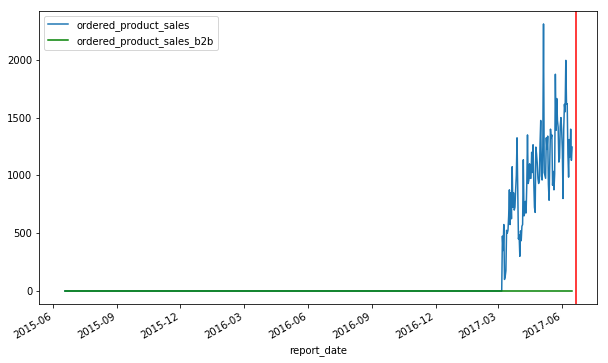

In [6]:
f = plotSellerHistory("8cb1b50e-d1d3-412f-9a71-9a16be81e629")

In [7]:
# for i in sellerPerformance.supplier_key.unique():
#     plotSellerHistory(i)

Inside of /plots folder in repository there are generated plots.

Effect of sesonality in the data is not clearly visible (I was expecting f.e. christmas increase in sales), thus I will not follow sesonality removal methods. 

### Feature engineering

In [8]:
# Should we sum up ordered_product_sales and ordered_product_sales_b2b ????
# This is domain knowledge, but seems good idea as total sales more about health of one's buisness,
# and simplifies problem

In [9]:
sellerPerformance['sales'] = sellerPerformance.ordered_product_sales + sellerPerformance.ordered_product_sales_b2b

In [10]:
sellerPerformance.head()

supplier_key report_date  ordered_product_sales  \
0  00179d2b-e696-4536-b530-e25ed838fae6  2018-10-24                1651.50   
1  00179d2b-e696-4536-b530-e25ed838fae6  2018-10-23                1728.16   
2  00179d2b-e696-4536-b530-e25ed838fae6  2018-10-22                2115.83   
3  00179d2b-e696-4536-b530-e25ed838fae6  2018-10-21                1304.69   
4  00179d2b-e696-4536-b530-e25ed838fae6  2018-10-20                 536.08   

   ordered_product_sales_b2b  units_ordered  units_ordered_b2b  \
0                        0.0            214                  0   
1                        0.0            193                  0   
2                        0.0            188                  0   
3                        0.0            160                  0   
4                        0.0             86                  0   

   units_refunded churn_date  did_churn    sales  
0               0        NaT      False  1651.50  
1               0        NaT      False  1728.16  
2               0        NaT      False  2115.83  
3               0        NaT      False  1304.69  
4               0        NaT      False   536.08

### Linear Fitting

My idea is to fit linear function to different time slices (last 3,6,12 months),
calculate slope and r^2 and use those as features for classification. 
The idea behind this is that such features should carry an information if given time series is accually rising, falling and if it is a steady linear trend. 

In [11]:
import fitting as fitting

There are plenty of cases of period of zero sales in the dataset, this whould affect fitting, thus those zeros are removed.
Similar issue is with the cases where the churn accutally had place - what happend after churn is also truncated.

In [12]:
def dropBegginningZeroSales(df):
    sales_beggining = df.sales.nonzero()[0][0]
    return df.iloc[sales_beggining:]

In [13]:
def dropEndingAfterChurn(df):
    return df.loc[:seller_df.iloc[0].churn_date]

In [14]:
def getSalesDF(seller_df):
    df = seller_df[["sales","report_date"]]
    df = df.set_index("report_date")
    df = df.sort_index()
    df = dropBegginningZeroSales(df)
    if (seller_df.iloc[0].did_churn):
        df = dropEndingAfterChurn(df)

    return df

In [15]:
def getSellerLinearFit(seller_df,lag_months,rolling_window):

    df = seller_df
    
    lag = np.timedelta64(lag_months, 'M')
    end_date = max(df.index)
    start_date = pd.to_datetime(end_date - lag)
    
    df = df.loc[start_date:]
    df = df.rolling(window=rolling_window).mean()
    df = df.dropna()
    
    return df, fitting.fit_df(df.sales, fitting.linear)

In [16]:
def plotSellerLinearFit(df, fit):
    
    xdata = np.arange(len(df.sales))
    ydata = np.array(df.sales)
    plt.plot(xdata, fitting.linear(xdata, *fit[0]))
    plt.plot(xdata, ydata)

Fitting examples:

Example R2 = 0.8331671636502086
Example slope = 10.028959458720172


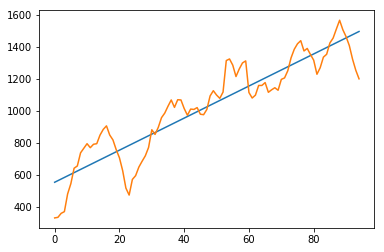

In [17]:
seller_df = sellerPerformance[sellerPerformance.supplier_key == "8cb1b50e-d1d3-412f-9a71-9a16be81e629"]

df_fit, fit = getSellerLinearFit(getSalesDF(seller_df), lag_months = 12, rolling_window = 7)
plotSellerLinearFit(df_fit, fit)
print("Example R2 = " + str(fit[2]))
print("Example slope = " + str(fit[0][0]))

Example R2 = 0.018865740753384985
Example slope = 0.9274504114242543


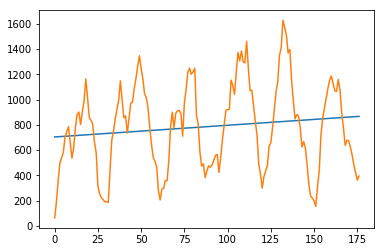

In [18]:
seller_df = sellerPerformance[sellerPerformance.supplier_key == "18d1cfea-a24d-4aed-aec7-9d91e5c77dea"]

df_fit, fit = getSellerLinearFit(getSalesDF(seller_df), lag_months = 6, rolling_window = 7)
plotSellerLinearFit(df_fit, fit)
print("Example R2 = " + str(fit[2]))
print("Example slope = " + str(fit[0][0]))

In [19]:
# average value of the last month can be handy - it would carry the infomration of the size of sales

In [20]:
def getAverageSalesLastMonth(df):

    end_date = max(df.index)
    start_date = pd.to_datetime(end_date - np.timedelta64(1, 'M'))

    return df.loc[start_date:].sales.mean()


### Feature space

In [21]:
# Let's build matrix with features desribing different windows of given timeseries

In [22]:
lags = [3, 6, 12] # those are acctually lengths of time windows
colNames = []

In [23]:
for i in lags:
    colNames.append("slope_%sm"%i)
    colNames.append("r2_%sm"%i)
    
colNames.append("target")
colNames.append("last_month_mean")

In [24]:
df = pd.DataFrame(np.nan, index=sellerPerformance.supplier_key.unique(), columns=colNames)

In [25]:
rolling_window = 7 # 

In [26]:
for i in df.index:
    seller_df = sellerPerformance[sellerPerformance.supplier_key == i]
    df.loc[i, "target"] = seller_df.iloc[0].did_churn
    truncated_df = getSalesDF(seller_df)

    for lag_months in lags:
        df_fit, fit = getSellerLinearFit(truncated_df, lag_months, rolling_window)
        
        slope = fit[0][0]
        col_n = "slope_%sm" % lag_months
        df.loc[i,col_n] = slope

        r2 = fit[2]
        col_n = "r2_%sm" % lag_months
        df.loc[i,col_n] = r2
  
        df.loc[i,"last_month_mean"] = getAverageSalesLastMonth(truncated_df)
        
    
        

In [27]:
df.head()

slope_3m     r2_3m    slope_6m  \
00179d2b-e696-4536-b530-e25ed838fae6  -11.142086  0.389031   -5.227959   
023f3e40-29a1-42a3-98c8-e0bcb0d91679    1.700873  0.459599   -0.168743   
031a13f1-5488-4ef8-a2fa-e55bb894c44e   -2.458865  0.078989   -0.746254   
03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5  473.607870  0.669728  101.525508   
0436c362-c373-4519-8c50-fca6f6a6243e    2.253254  0.176931    2.269801   

                                         r2_6m  slope_12m    r2_12m target  \
00179d2b-e696-4536-b530-e25ed838fae6  0.337657   0.936728  0.035918  False   
023f3e40-29a1-42a3-98c8-e0bcb0d91679  0.024562  -0.180088  0.063513  False   
031a13f1-5488-4ef8-a2fa-e55bb894c44e  0.034289   2.424043  0.391123   True   
03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5  0.241243  30.975447  0.161770   True   
0436c362-c373-4519-8c50-fca6f6a6243e  0.570330   0.997213  0.529162  False   

                                      last_month_mean  
00179d2b-e696-4536-b530-e25ed838fae6       866.688387  
023f3e40-29a1-42a3-98c8-e0bcb0d91679       131.806452  
031a13f1-5488-4ef8-a2fa-e55bb894c44e       669.359355  
03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5     35919.209677  
0436c362-c373-4519-8c50-fca6f6a6243e       411.719032

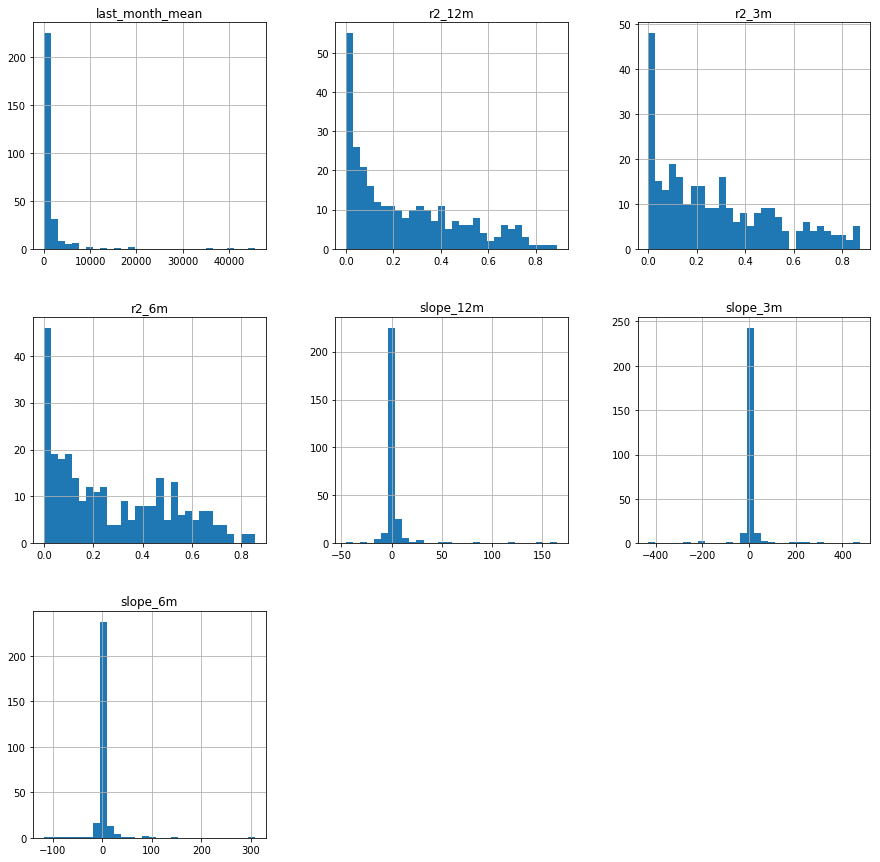

In [28]:
df.hist(bins = 30, figsize = (15,15));

In [29]:
columns_to_trim = ["slope_12m", "slope_6m","slope_3m","last_month_mean"]

In [30]:
for i in columns_to_trim:
    double_std = 3 * np.std(df[i])
    df[i] = np.where(df[i] > double_std, double_std, df[i])
    df[i] = np.where(df[i] < -double_std, -double_std, df[i])

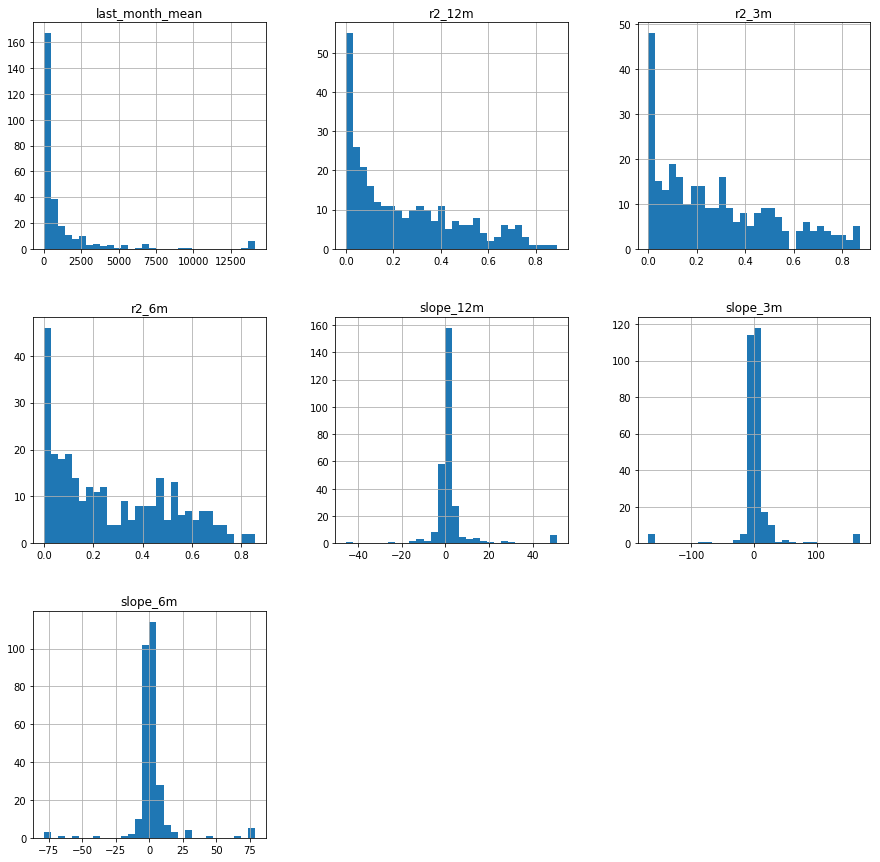

In [31]:
df.hist(bins = 30, figsize = (15,15));

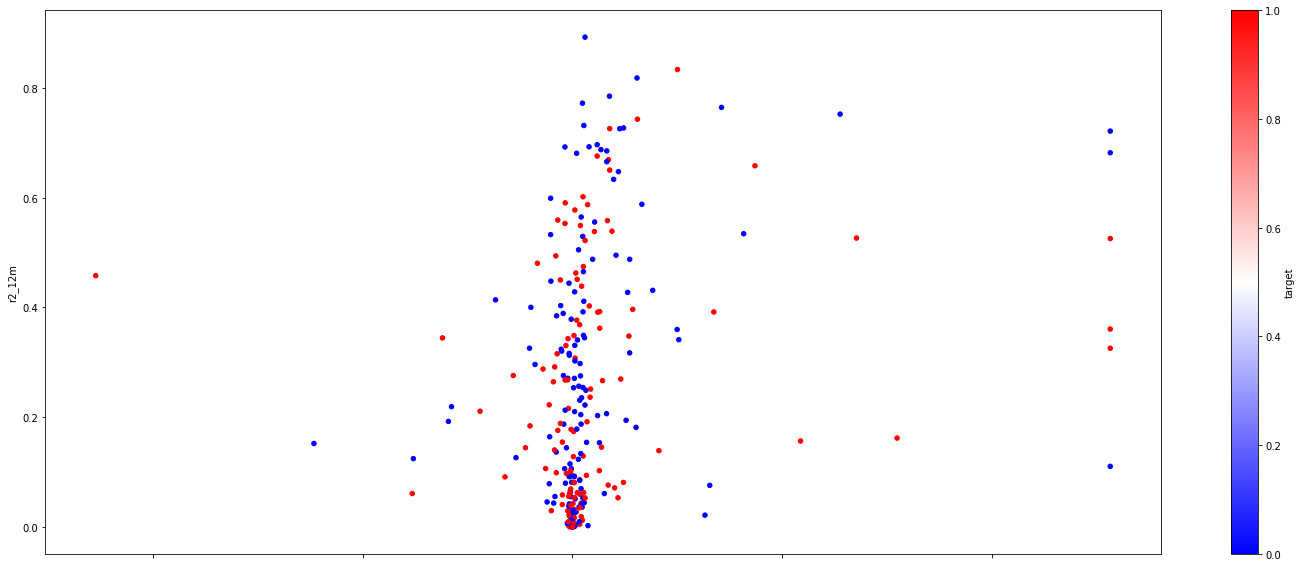

In [32]:
df.astype(float).plot.scatter('slope_12m', 'r2_12m', c='target', cmap='bwr', figsize=(25, 10))

## Binary Classification

Having sales history data, prepare a model classifying the trend of sales as inclining or declining [or any other you see useful] and test the accuracy of model on given dataset. 

#### Dataframe used in classification:

In [33]:
df.head(10)

slope_3m     r2_3m   slope_6m  \
00179d2b-e696-4536-b530-e25ed838fae6  -11.142086  0.389031  -5.227959   
023f3e40-29a1-42a3-98c8-e0bcb0d91679    1.700873  0.459599  -0.168743   
031a13f1-5488-4ef8-a2fa-e55bb894c44e   -2.458865  0.078989  -0.746254   
03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5  168.568501  0.669728  78.857167   
0436c362-c373-4519-8c50-fca6f6a6243e    2.253254  0.176931   2.269801   
0574ad4e-5331-4e0b-9dd5-70d8fd3ba01b   30.947919  0.081039  18.196591   
05bcf67e-56a1-4586-955d-c46cdb1facea    2.991512  0.153133   1.108434   
073941ba-16e0-4a1f-825e-1cd94b9d50cb    0.503400  0.115421  -0.220455   
082ba7d5-7b68-46e3-8a53-fc4d52104e28  168.568501  0.423473  78.857167   
08bf0731-752f-4f9c-ad76-472e3d471b8f   -4.834143  0.146624   1.647805   

                                         r2_6m  slope_12m    r2_12m target  \
00179d2b-e696-4536-b530-e25ed838fae6  0.337657   0.936728  0.035918  False   
023f3e40-29a1-42a3-98c8-e0bcb0d91679  0.024562  -0.180088  0.063513  False   
031a13f1-5488-4ef8-a2fa-e55bb894c44e  0.034289   2.424043  0.391123   True   
03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5  0.241243  30.975447  0.161770   True   
0436c362-c373-4519-8c50-fca6f6a6243e  0.570330   0.997213  0.529162  False   
0574ad4e-5331-4e0b-9dd5-70d8fd3ba01b  0.197176   4.878750  0.080918   True   
05bcf67e-56a1-4586-955d-c46cdb1facea  0.092900   1.060868  0.348950  False   
073941ba-16e0-4a1f-825e-1cd94b9d50cb  0.053984  -1.140994  0.449832   True   
082ba7d5-7b68-46e3-8a53-fc4d52104e28  0.360370  51.315232  0.360370   True   
08bf0731-752f-4f9c-ad76-472e3d471b8f  0.082300   2.617202  0.392190   True   

                                      last_month_mean  
00179d2b-e696-4536-b530-e25ed838fae6       866.688387  
023f3e40-29a1-42a3-98c8-e0bcb0d91679       131.806452  
031a13f1-5488-4ef8-a2fa-e55bb894c44e       669.359355  
03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5     14122.704720  
0436c362-c373-4519-8c50-fca6f6a6243e       411.719032  
0574ad4e-5331-4e0b-9dd5-70d8fd3ba01b      2377.165161  
05bcf67e-56a1-4586-955d-c46cdb1facea       561.915806  
073941ba-16e0-4a1f-825e-1cd94b9d50cb        78.764839  
082ba7d5-7b68-46e3-8a53-fc4d52104e28     13552.371935  
08bf0731-752f-4f9c-ad76-472e3d471b8f       497.050968

In [34]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics


/home/jerzy/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
X = df.loc[:, df.columns != 'target']
y = df.target.astype('bool')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [37]:
clf = svm.SVC(kernel='rbf', C = 10, gamma = 0.01) 

In [38]:
clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
y_pred = clf.predict(X_test)

In [40]:
metrics.accuracy_score(y_test, y_pred)

0.6511627906976745

In [41]:
metrics.confusion_matrix(y_test, y_pred)

array([[41, 10],
       [20, 15]])

In [42]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.67      0.80      0.73        51
       True       0.60      0.43      0.50        35

avg / total       0.64      0.65      0.64        86



In [43]:
cross_val_score(clf, X, y, cv=5)

array([0.60344828, 0.56896552, 0.57142857, 0.625     , 0.60714286])

## Statistical test

Check whether is there correlation of trend movement to churn event (churn happened if there is a date given in churn dataset – if there is no date, the client is still using our service) m – verify the hipothesis stated by Customer Service.

In [135]:
# Let's perform an acctual statistical test to examine the significance of the association between trend 
# and churn event - f.e. Fisher exact test.
# For that, there is needed a binary assigment of trend / not trend. 
# I will implement simple statistical model for that - getTrendFactor() 
# It is difference between year ending and rest of the year over difference between procentiles.


In [121]:
import math
def getTrendFactor(df):

    lag = np.timedelta64(12, 'M')
    end_date = max(df.index)
    start_date = max(min(df.index), pd.to_datetime(end_date - lag))
    df = df.loc[start_date:]

    denominator = np.percentile(df.sales, 95)-np.percentile(df.sales, 5)

    df_last_month = df.loc[end_date-np.timedelta64(2, 'M') : end_date];
    df_rest = df.loc[start_date : end_date-np.timedelta64(2, 'M')];
    
    nominator = abs(df_last_month.sales.mean() - df_rest.sales.mean());
    
    result = nominator / denominator;


    return result  

In [122]:
df = pd.DataFrame(np.nan, index=sellerPerformance.supplier_key.unique(), columns=["trend_factor"])

In [123]:
for i in df.index:
    seller_df = sellerPerformance[sellerPerformance.supplier_key == i]
    df.loc[i, "target"] = 1 if seller_df.iloc[0].did_churn else 0
    truncated_df = getSalesDF(seller_df)
    df.loc[i, "trend_factor"] = getTrendFactor(truncated_df)

/home/jerzy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [124]:
df = df.replace([np.inf, -np.inf], np.nan).dropna() #todo: trace a bug

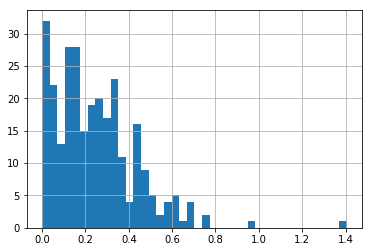

In [126]:
df.trend_factor.hist(bins = 40)

In [127]:
df.head()

trend_factor  target
00179d2b-e696-4536-b530-e25ed838fae6      0.179788     0.0
023f3e40-29a1-42a3-98c8-e0bcb0d91679      0.045129     0.0
031a13f1-5488-4ef8-a2fa-e55bb894c44e      0.131482     1.0
03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5      0.758802     1.0
0436c362-c373-4519-8c50-fca6f6a6243e      0.638380     0.0

In [128]:
df["trend_binary"] = np.where(df["trend_factor"]>0.4, 1, 0)

In [129]:
df.head()

trend_factor  target  trend_binary
00179d2b-e696-4536-b530-e25ed838fae6      0.179788     0.0             0
023f3e40-29a1-42a3-98c8-e0bcb0d91679      0.045129     0.0             0
031a13f1-5488-4ef8-a2fa-e55bb894c44e      0.131482     1.0             0
03d96d8a-7178-4f7d-a8f2-8ef1a643ecd5      0.758802     1.0             1
0436c362-c373-4519-8c50-fca6f6a6243e      0.638380     0.0             1

In [130]:
ct = pd.crosstab(df.target, df.trend_binary)

In [131]:
ct

trend_binary    0   1
target               
0.0           124  33
1.0           105  20

In [132]:
import scipy.stats as stats

In [133]:
oddsratio, pvalue = stats.fisher_exact(ct)

In [134]:
pvalue

0.35739934287053277

## Conclusions

There seems to be no obvoius correlation between trend in sales of payability customers and churn events.

From the time series plots overview it seems that there are plenty of incline / decline trends in both classes, it is confirmed in weak results of performed experiments. 

It appears that the issue is more complex - in further research I would group the dataset "by hand" in more classes - there are visibale cases like "one time shot" buissesses that are quicly reaching peak and falling down. That could lead to better modeling. In another hand it also leads natturally to segmentation of the clients and mining for buisness insights taking different types of payability clients in consideration while churn analysis.